# Note
This notebook is meant to accompany the blog post at:  https://blog.zakjost.com/post/an-example-of-graph-convolutional-networks/

In [581]:
import numpy as np
import pandas as pd
import torch as th
import dgl
from dgl.data import CiteseerGraphDataset
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
th.__version__, dgl.__version__

('1.5.0', '0.5.2')

# Data

In [ ]:
def plot_features(features, labels, tsne_args, cmap='tab20'):
    proj = TSNE(random_state=0, **tsne_args).fit_transform(features)
    fig, ax = plt.subplots(figsize=(8,8))
    scatter = ax.scatter(proj[:,0], proj[:,1], c=labels, s=2, cmap=cmap)
    plt.legend(*scatter.legend_elements())
    ax.set(title='TSNE of features')
    _ = ax.grid()

In [3]:
dataset = CiteseerGraphDataset()
g = dataset[0]
# get node feature
feat = g.ndata['feat']
# get data split
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
# get labels
label = g.ndata['label']

num_class = label.unique().shape[0]

Loading from cache failed, re-processing.


/home/ec2-user/anaconda3/envs/zak_torch/lib/python3.6/site-packages/dgl/data/citation_graph.py:258: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [141]:
train_nodes = np.arange(g.num_nodes())[train_mask]
val_nodes = np.arange(g.num_nodes())[val_mask]
test_nodes = np.arange(g.num_nodes())[test_mask]

**Note: Nodes 620-2311 are not in any of the Train/Valid/Test sets!** 

In [140]:
# Assign a dataset label to each node for plotting purposes
train_val_test_label = np.zeros(g.num_nodes())
train_val_test_label[train_mask] = 1
train_val_test_label[val_mask] = 2
train_val_test_label[test_mask] = 3
train_val_test_label

array([1., 1., 1., ..., 3., 3., 3.])

In [596]:
feat.shape

torch.Size([3327, 3703])

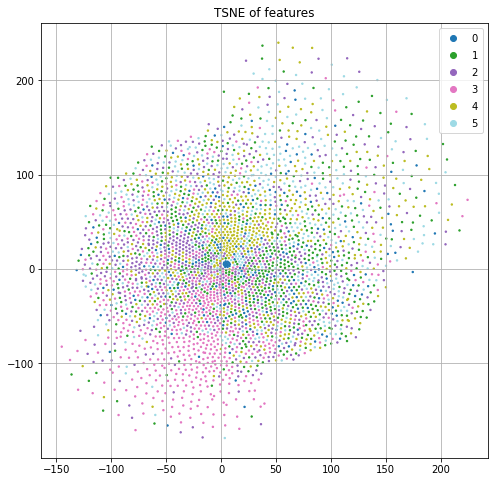

In [673]:
plot_features(
    feat.numpy(), label.numpy(), 
    {'perplexity': 15},
)

# Baseline Models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

In [5]:
baseline_acc_val = accuracy_score(label[val_mask], np.random.randint(0, 6, label[val_mask].shape[0]))
baseline_ll_val = log_loss(label[val_mask], np.zeros((label[val_mask].shape[0], 6))+1/6)
print(f'Baseline accuracy = {baseline_acc_val}, Baseline LogLoss = {baseline_ll_val}')

Baseline accuracy = 0.156, Baseline LogLoss = 1.7917594692280547


In [664]:
def buildLR(X_train, y_train, X_val, y_val, static_hps):
    static_hps.update({'n_jobs': -1})
    clf = LogisticRegression(**static_hps)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_val)
    acc = accuracy_score(y_val, np.argmax(y_pred, axis=1))
    ll = log_loss(y_val, y_pred)
    return clf, acc, ll

In [665]:
results = dict()
for i, c in enumerate([0.01, 0.1, 1.0, 10.0, 100., 1000., 1e4, 1e5, 1e6]):
    hps = {
        'C': c, 
        #'penalty': 'l1', 
        #'solver': 'saga', 
        #'max_iter': 2000, 
        'multi_class': 'multinomial'
    }
    clf, acc, ll = buildLR(feat[train_mask], label[train_mask], feat[val_mask], label[val_mask], hps)
    results[c] = {'acc': acc, 'll': ll}

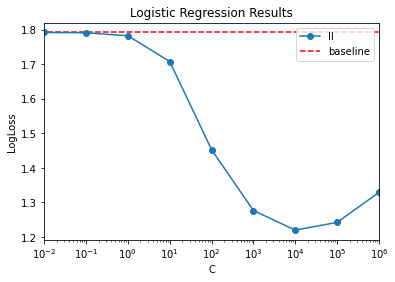

In [666]:
ax = pd.DataFrame.from_dict(results, orient='index')['ll'].plot(style='-o')
ax.hlines([baseline_ll_val], 0, max(results.keys()), linestyle='--', color='red', label='baseline')
#ax.set_xscale('log')
ax.legend()
_ = ax.set(xlabel='C', ylabel='LogLoss', xscale='log', title='Logistic Regression Results')

In [667]:
clf, acc, ll = buildLR(
    feat[train_mask], label[train_mask], feat[val_mask], label[val_mask], 
    {'C': 1e4, }#'penalty': 'l1', 'solver': 'saga', 'max_iter': 8000, 'multi_class': 'multinomial'}
)
print(f'LogReg accuracy = {acc}, LogReg LogLoss = {ll}')

LogReg accuracy = 0.55, LogReg LogLoss = 1.2200278042558057


## Random Forest

In [668]:
from sklearn.ensemble import RandomForestClassifier

In [669]:
def buildRF(X_train, y_train, X_val, y_val, static_hps):
    static_hps.update({'n_jobs': -1})
    clf = RandomForestClassifier(**static_hps)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_val)
    acc = accuracy_score(y_val, np.argmax(y_pred, axis=1))
    ll = log_loss(y_val, y_pred)
    return clf, acc, ll

In [670]:
results_rf = dict()
for i, d in enumerate([6, 10, 14, 18, 22, 26]):
    hps = {'n_estimators': 1000, 'max_depth': d}
    clf, acc, ll = buildRF(feat[train_mask], label[train_mask], feat[val_mask], label[val_mask], hps)
    results_rf[d] = {'acc': acc, 'll': ll}

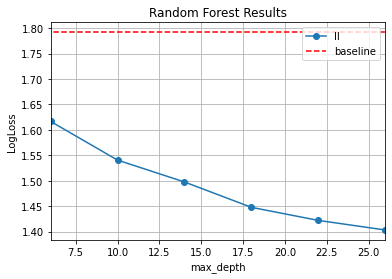

In [671]:
ax = pd.DataFrame.from_dict(results_rf, orient='index')['ll'].plot(style='-o')
ax.hlines([baseline_ll_val], 0, max(results_rf.keys()), linestyle='--', color='red', label='baseline')
ax.legend()
ax.grid()
_ = ax.set(xlabel='max_depth', ylabel='LogLoss', title='Random Forest Results')

In [672]:
print(f'RF accuracy = {acc}, RF LogLoss = {ll}')

RF accuracy = 0.57, RF LogLoss = 1.4033312325954899


# GCN
This code is based on the official DGL example [here](https://github.com/dmlc/dgl/tree/master/examples/pytorch/gcn)

In [587]:
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.sampling import sample_neighbors

In [608]:
def sample_blocks(g, fanouts, seeds):
    blocks = []
    #seeds = th.tensor(seeds).long()
    cur = seeds
    for fanout in fanouts:
        if fanout <= 0:
            frontier = dgl.in_subgraph(g, cur)
        else:
            frontier = dgl.sampling.sample_neighbors(g, cur, fanout)
        block = dgl.to_block(frontier, cur)
        cur = {}
        for ntype in block.srctypes:
            cur[ntype] = block.srcnodes[ntype].data[dgl.NID]
        blocks.insert(0, block)
    return seeds, blocks

def get_mhop_size(g, mhops, nodes):
    mhop_sizes = list()
    for node in nodes:
        seeds, blocks = sample_blocks(g, [-1]*mhops, [node])
        mhop_sizes.append(blocks[0].num_nodes())
    return mhop_sizes

def get_mhop_labels(g, mhops, nodes, train_idx_max):
    mhop_labels = list()
    for node in nodes:
        seeds, blocks = sample_blocks(g, [-1]*mhops, [node])
        mhop_labels.append((blocks[0].ndata[dgl.NID]['_N']<=train_idx_max).sum().item())
    return mhop_labels

def draw_kkl(G, label_map, node_color, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    nx_G = G.to_networkx().to_undirected()
    pos = nx.spring_layout(nx_G, k=5/np.sqrt(G.num_nodes()))
    nx.draw(nx_G, pos, with_labels=True, labels=label_map, node_color=node_color, ax=ax, **kwargs)
    return nx_G, pos

def get_next_hop(g, seeds):
    _, blocks = sample_blocks(g.to('cpu'), [-1], seeds)
    hop = blocks[0].ndata[dgl.NID]['_N'].numpy()
    return hop

In [534]:
class GCN(nn.Module):
    def __init__(self,
                 g, # graph
                 in_feats, # number of input features
                 n_hidden, # number of hidden layer neurons
                 n_classes, # number of prediction classes
                 n_layers, # number of GCN layers
                 activation, # activation function for all but last layer
                 dropout): # dropout applied to output of layers
        super(GCN, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        gcn_kwargs = {'allow_zero_in_degree': True, 'norm': 'right'}
        self.layers.append(GraphConv(in_feats, n_hidden, activation=activation, **gcn_kwargs))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation, **gcn_kwargs))
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes, **gcn_kwargs))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        return h

In [535]:
def plot_losses(train_loss, val_loss):
    fig, ax = plt.subplots()
    kwargs = {'marker': 'o', 'markersize': 3}
    ax.plot(train_loss, label='Train', **kwargs)
    ax.plot(val_loss, label='Val', **kwargs)
    ax.grid()
    ax.legend()
    ax.set(xlabel='Epoch', ylabel='CrossEntropy', title='Loss vs Epoch')

def evaluate(model, features, labels, mask, device):
    model.eval()

    with th.no_grad():

        logits = model(features.to(device))[mask]
        labels = labels[mask].to(device)
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def train(model, features, labels, train_mask, val_mask, test_mask,
          lr, wd, epochs, device, es_iters=None, schedule_factor=0.1):
    
    loss_fcn = nn.CrossEntropyLoss()
    
    params = model.parameters()

    opt = th.optim.Adam(params, lr=lr, weight_decay=wd)
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
        opt, 'min', patience=5, factor=schedule_factor,
    )
    
    train_loss = []
    val_loss = []
    val_acc = []
    
    # If early stopping criteria, initialize relevant parameters
    if es_iters:
        print("Early stopping monitoring on")
        loss_min = 1e8
        es_i = 0

    for epoch in range(epochs):
        model.train()

        # forward
        logits = model(features.to(device))
        loss = loss_fcn(logits[train_mask], labels[train_mask].to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        acc = evaluate(model, features, labels, val_mask, device)
        train_loss.append(loss.item())
        val_loss.append(loss_fcn(logits[val_mask], labels[val_mask].to(device)).item())
        val_acc.append(acc)
        scheduler.step(val_loss[-1])
        
        if es_iters:
            if val_loss[-1] < loss_min:
                loss_min = val_loss[-1]
                es_i = 0
            else:
                es_i += 1

            if es_i >= es_iters:
                print(f"Early stopping at epoch={epoch+1}")
                break

    acc = evaluate(model, features, labels, test_mask, device)
    print("Test accuracy {:.2%}".format(acc))
    return train_loss, val_loss, val_acc

In [16]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
self_loop = True
if self_loop:
    g = dgl.remove_self_loop(g)
    g = dgl.add_self_loop(g)
else:
    g = dgl.remove_self_loop(g)

In [20]:
g = g.int().to(device)

# GCNs with no training

## Without Features

In [571]:
eye_feat = th.eye(feat.shape[0]) # identity matrix

In [572]:
gcn_wo_features_1 = GCN(
    g=g,
    in_feats=eye_feat.shape[1],
    n_hidden=32, # number of hidden layer neurons
    n_classes=num_class,
    n_layers=5, # number of GCN layers
    activation=nn.ReLU(), # activation function for all but last layer
    dropout=0.5,
).to(device)

In [574]:
proj_wo = TSNE(perplexity=15).fit_transform(gcn_wo_features_1(eye_feat.to(device)).detach().cpu().numpy())

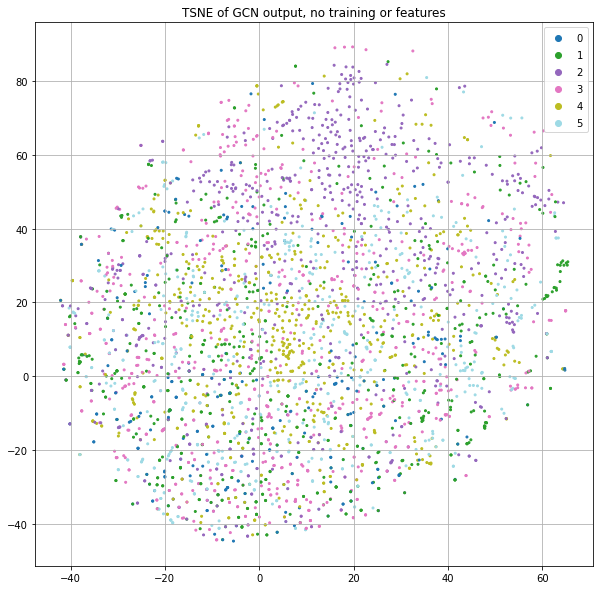

In [687]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wo[:,0], proj_wo[:,1], 
    c=label.numpy(), # label
    s=4, cmap='tab20'
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of GCN output, no training or features')
_ = ax.grid()

In [586]:
idx_roi_wo = np.array([
    72,  518,  997, 1146, 1197, 1534, 1896, 2170, 2702, 2703, 2707
])

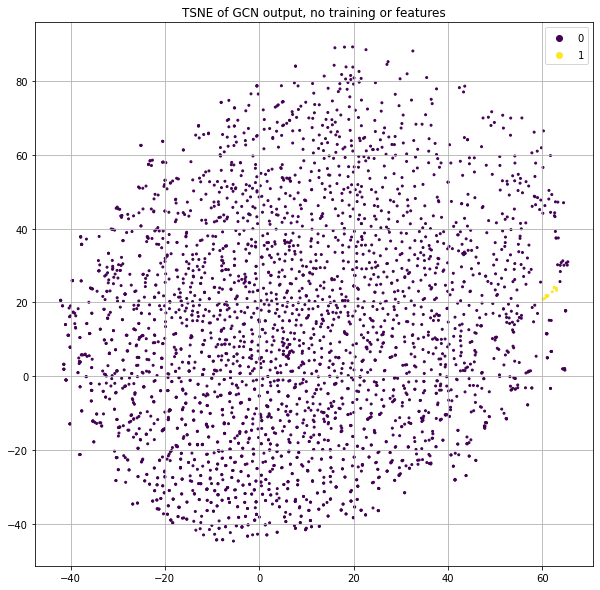

In [688]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wo[:,0], proj_wo[:,1], 
    c=np.array([n in idx_roi_wo for n in range(proj_wo.shape[0])]), # label
    s=4,
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of GCN output, no training or features')
_ = ax.grid()

In [590]:
mhops = 1
_, blocks_wo = sample_blocks(g.to('cpu'), [-1]*mhops, idx_roi_wo)
nns_wo = blocks_wo[0].ndata[dgl.NID]['_N'].numpy()

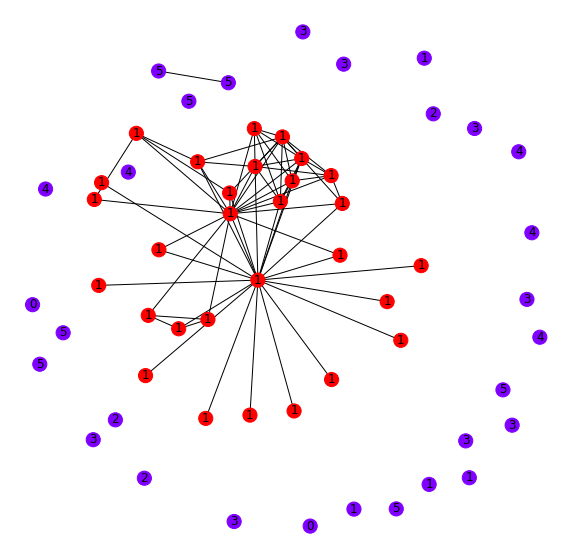

In [615]:
# Red = one of the original nodes + neighbors, Blue = a randomly sampled node
node_sample = np.concatenate([nns_wo, np.random.randint(0, g.num_nodes(), nns_wo.shape[0])])
label_map = {
    i: label[idx].numpy()
    for i, idx in enumerate(node_sample)
}
node_color = np.array([n in nns_wo for n in node_sample])*1
nx_G, pos = draw_kkl(
    g.subgraph(node_sample).to('cpu'), 
    label_map=label_map, 
    #node_color=label[nns].numpy(), 
    node_color=node_color,
    cmap='rainbow',
    node_size=200,
)

## With Features

In [695]:
gcn_w_features_1 = GCN(
    g=g,
    in_feats=feat.shape[1],
    n_hidden=32, # number of hidden layer neurons
    n_classes=num_class,
    n_layers=5, # number of GCN layers
    activation=nn.ReLU(), # activation function for all but last layer
    dropout=0.5,
).to(device)

In [696]:
gcn_w_features_1.eval()
proj_wf0 = TSNE(perplexity=15).fit_transform(gcn_w_features_1(feat.to(device)).detach().cpu().numpy())

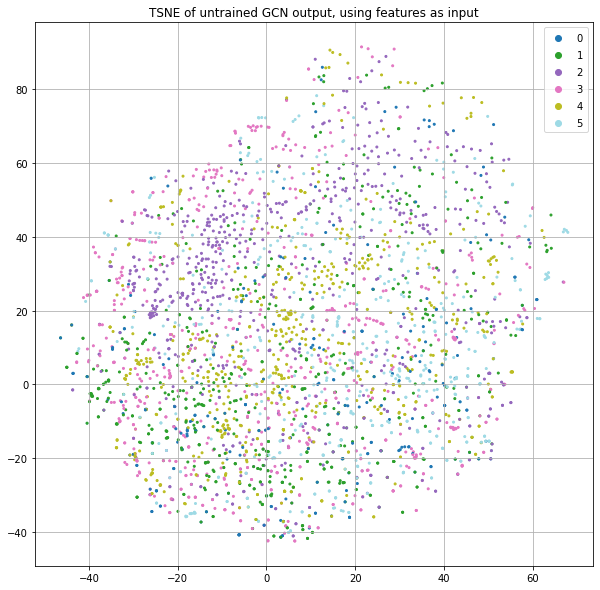

In [699]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wf0[:,0], proj_wf0[:,1], 
    c=label.numpy(), # label
    s=4, cmap='tab20'
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of untrained GCN output, using features as input')
_ = ax.grid()

# Trained GCNs

## Without Features

In [367]:
gcn_wo_features2 = GCN(
    g=g,
    in_feats=eye_feat.shape[1],
    n_hidden=32, # number of hidden layer neurons
    n_classes=num_class,
    n_layers=1, # number of GCN layers
    activation=nn.ReLU(), # activation function for all but last layer
    dropout=0.5,
).to(device)

In [368]:
train_loss_wof2, val_loss_wof2, val_acc_wof2 = train(
    gcn_wo_features2, eye_feat, label, train_mask, val_mask, test_mask,
    lr=1e-2, wd=1e-5, epochs=500, device=device, es_iters=30)

Early stopping monitoring on
Early stopping at epoch=104
Test accuracy 50.90%


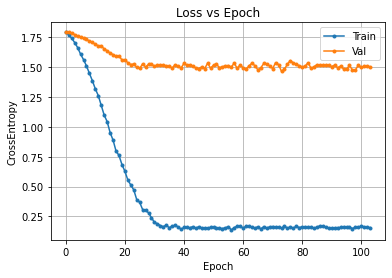

In [369]:
plot_losses(train_loss_wof2, val_loss_wof2)

In [384]:
proj = TSNE(perplexity=15).fit_transform(gcn_wo_features2(eye_feat.to(device)).detach().cpu().numpy())

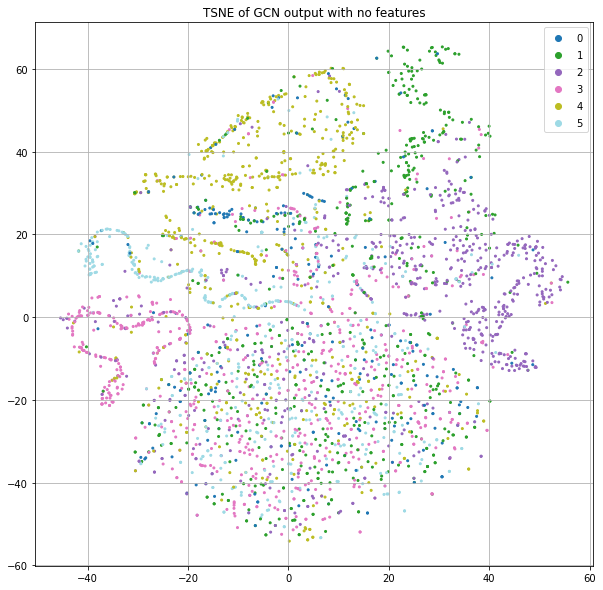

In [700]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj[:,0], proj[:,1], 
    c=label.numpy(), # label
    s=4, cmap='tab20'
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of GCN output with no features')
_ = ax.grid()

In [386]:
loss_fnc = nn.CrossEntropyLoss(reduction='none')
gcn_wo_features2.eval()
logits = gcn_wo_features2(eye_feat.to(device))
loss = loss_fnc(logits, label.to(device)).detach().cpu().numpy()

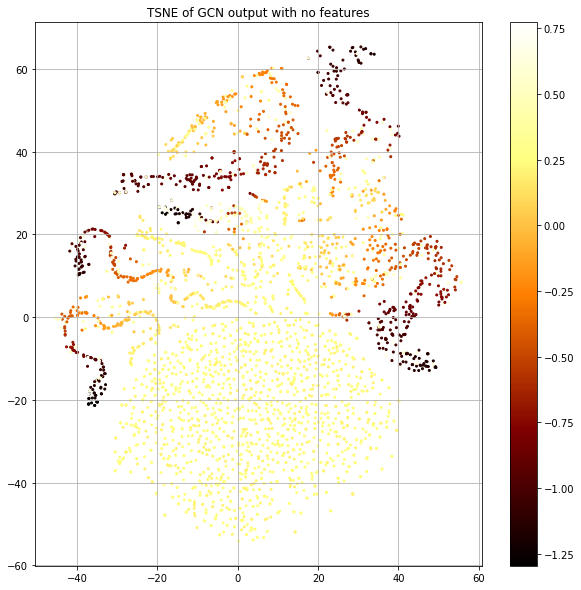

In [701]:
# Color by loss
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj[:,0], proj[:,1], 
    c=np.log10(loss+1e-7), # loss 
    s=4, cmap='afmhot'#'afmhot'
)

plt.colorbar(scatter)
ax.set(title='TSNE of GCN output with no features')
_ = ax.grid()

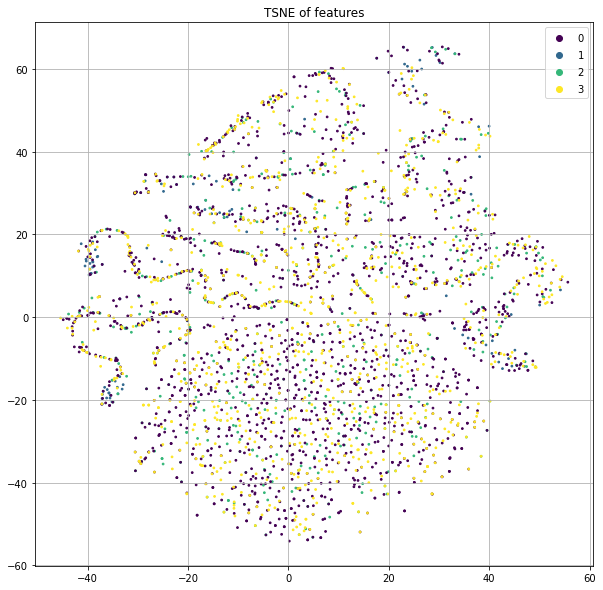

In [388]:
# Color by train/val/test label
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj[:,0], proj[:,1],
    c=train_val_test_label,
    s=3,
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of features')
_ = ax.grid()

In [389]:
mhops = 2
all_mhop_labels = get_mhop_labels(g.to('cpu'), mhops, np.arange(g.num_nodes()), train_nodes.max())

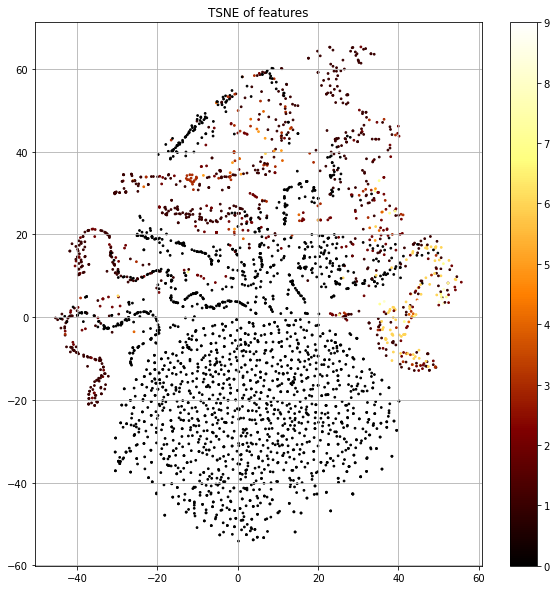

In [390]:
# Color by number of labels in m-hop neighborhood
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj[:,0], proj[:,1], 
    c=np.array(all_mhop_labels),
    s=3, cmap='afmhot',
)

plt.colorbar(scatter)
ax.set(title='TSNE of features')
_ = ax.grid()

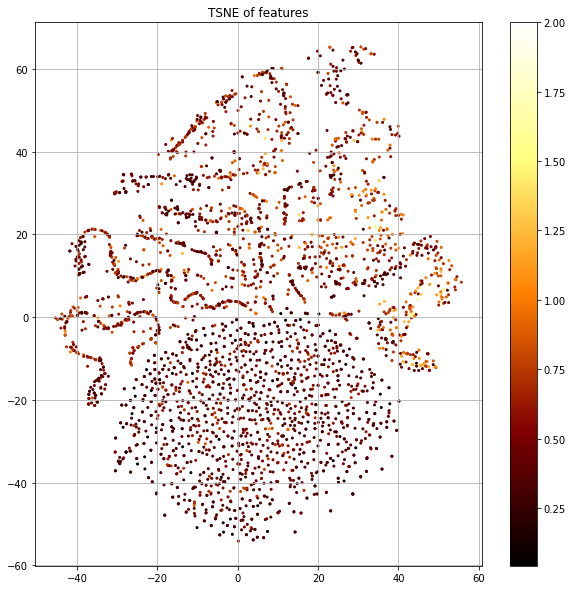

In [391]:
# Color by (LOG10) degree / number of neighbors
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj[:,0], proj[:,1], 
    c=np.log10(g.in_degrees().cpu().numpy() + 1e-1),
    s=4, cmap='afmhot'
)

plt.colorbar(scatter)
ax.set(title='TSNE of features')
_ = ax.grid()

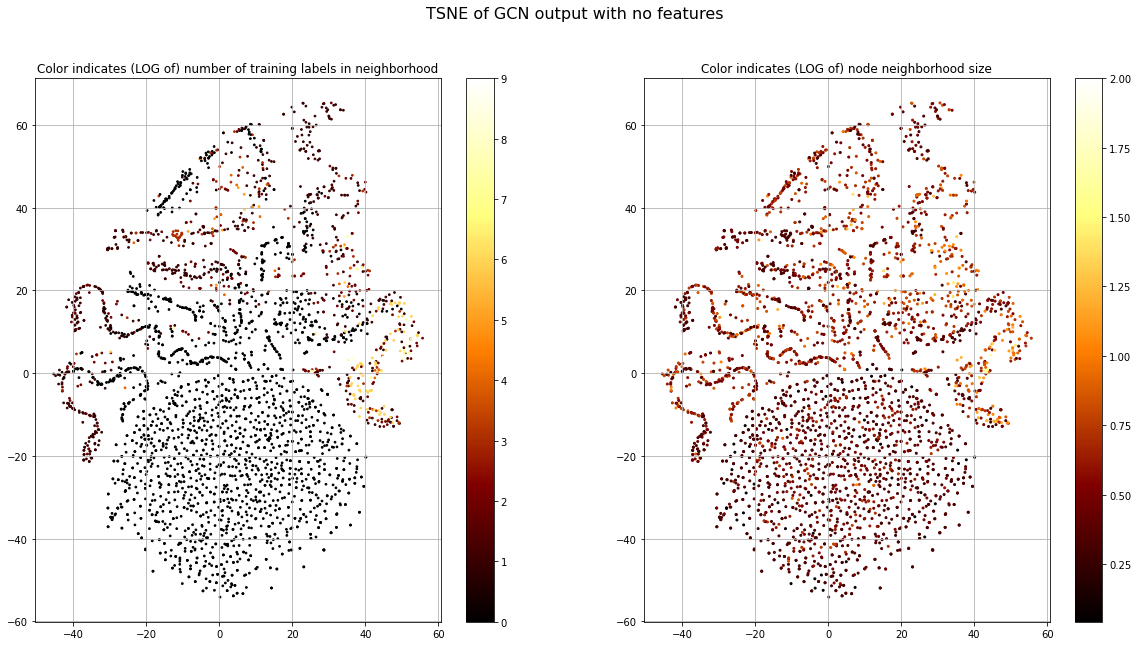

In [709]:
# Joint plot
fig, (ax1, ax2) = plt.subplots(figsize=(20,10), ncols=2)
scatter1 = ax1.scatter(
    proj[:,0], proj[:,1], 
    c=np.array(all_mhop_labels),
    s=3, cmap='afmhot',
)

plt.colorbar(scatter1, ax=ax1)
ax1.set(title='Color indicates (LOG of) number of training labels in neighborhood')
_ = ax1.grid()

scatter2 = ax2.scatter(
    proj[:,0], proj[:,1], 
    c=np.log10(g.in_degrees().cpu().numpy() + 1e-1),
    s=4, cmap='afmhot'
)

plt.colorbar(scatter2, ax=ax2)
ax2.set(title='Color indicates (LOG of) node neighborhood size')
_ = ax2.grid()

_ = fig.suptitle('TSNE of GCN output with no features', fontsize=16)

In [396]:
idx_roi = np.array([
    483,  609,  684,  764,  851,  874, 1091, 1471, 1619, 1770, 1823,
    2076, 2159, 2208, 2321, 2494, 2605, 2896, 2897, 2954, 3153])

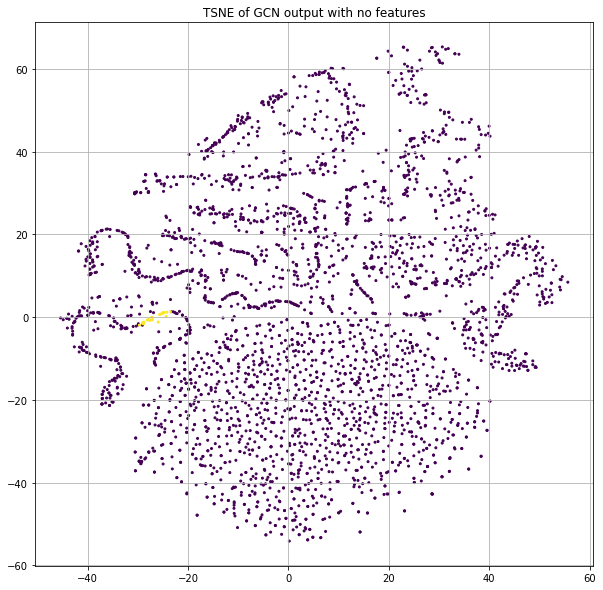

In [710]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj[:,0], proj[:,1], 
    c=np.array([n in idx_roi for n in range(proj.shape[0])]*1),
    s=4,
)

ax.set(title='TSNE of GCN output with no features')
_ = ax.grid()

In [400]:
# Number of labeled training nodes in the neighborhood of each node
np.array(all_mhop_labels)[idx_roi]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [401]:
label[idx_roi].numpy()

array([3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4])

In [402]:
train_val_test_label[idx_roi]

array([2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3.,
       3., 3., 3., 3.])

In [406]:
mhops = 1
_, blocks = sample_blocks(g.to('cpu'), [-1]*mhops, idx_roi)
nns = blocks[0].ndata[dgl.NID]['_N'].numpy()

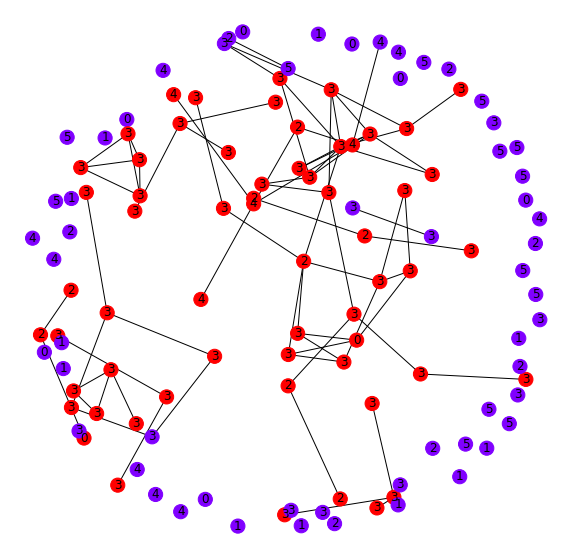

In [712]:
# Plot these nodes/neighbors along with a random sample of nodes
# Red = nodes of interest, blue = random sample
node_sample2 = np.concatenate([nns, np.random.randint(0, g.num_nodes(), nns.shape[0])])
label_map = {
    i: label[idx].numpy()
    for i, idx in enumerate(node_sample2)
}
node_color = np.array([n in nns for n in node_sample2])*1
nx_G, pos = draw_kkl(
    g.subgraph(node_sample2).to('cpu'), 
    label_map=label_map,  
    node_color=node_color,
    cmap='rainbow',
    node_size=200,
)

## With Features

In [536]:
gcn_w_features2 = GCN(
    g=g,
    in_feats=feat.shape[1],
    n_hidden=32, # number of hidden layer neurons
    n_classes=num_class,
    n_layers=1, # number of GCN layers
    activation=nn.ReLU(), # activation function for all but last layer
    dropout=0.5,
).to(device)

In [537]:
train_loss_wf2, val_loss_wf2, val_acc_wf2 = train(
    gcn_w_features2, feat, label, train_mask, val_mask, test_mask,
    lr=1e-2, wd=1e-3, epochs=500, device=device, es_iters=30)

Early stopping monitoring on
Early stopping at epoch=160
Test accuracy 70.20%


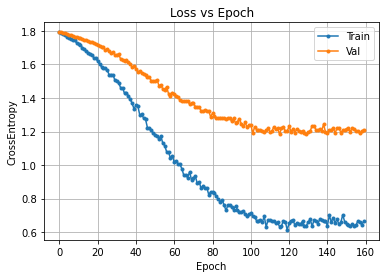

In [538]:
plot_losses(train_loss_wf2, val_loss_wf2)

In [539]:
gcn_w_features2.eval()
logits_wf = gcn_w_features2(feat.to(device))
loss_wf = loss_fnc(logits_wf, label.to(device)).detach().cpu().numpy()

In [540]:
proj_wf = TSNE(perplexity=15).fit_transform(gcn_w_features2(feat.to(device)).detach().cpu().numpy())

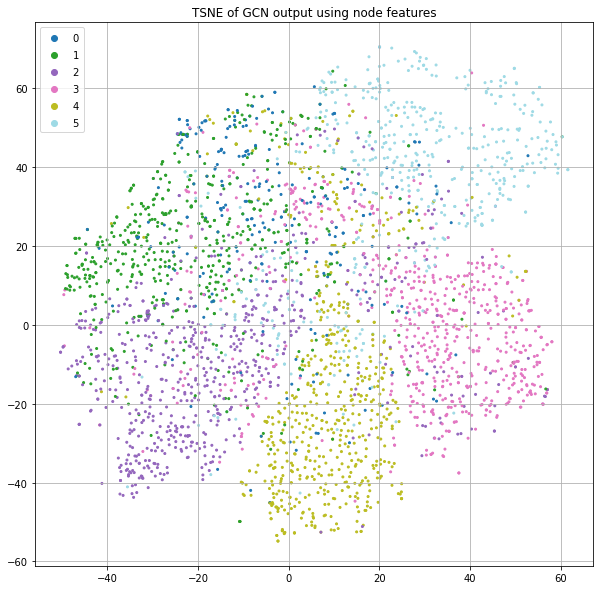

In [713]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wf[:,0], proj_wf[:,1], 
    c=label.numpy(), # label
    s=4, cmap='tab20'
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of GCN output using node features')
_ = ax.grid()

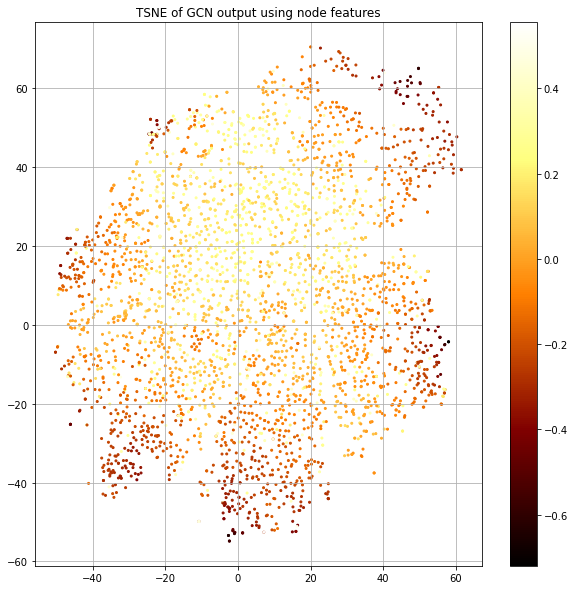

In [714]:
# Color by loss
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wf[:,0], proj_wf[:,1], 
    c=np.log10(loss_wf+1e-7), # loss 
    s=4, cmap='afmhot'#'afmhot'
)

plt.colorbar(scatter)
ax.set(title='TSNE of GCN output using node features')
_ = ax.grid()

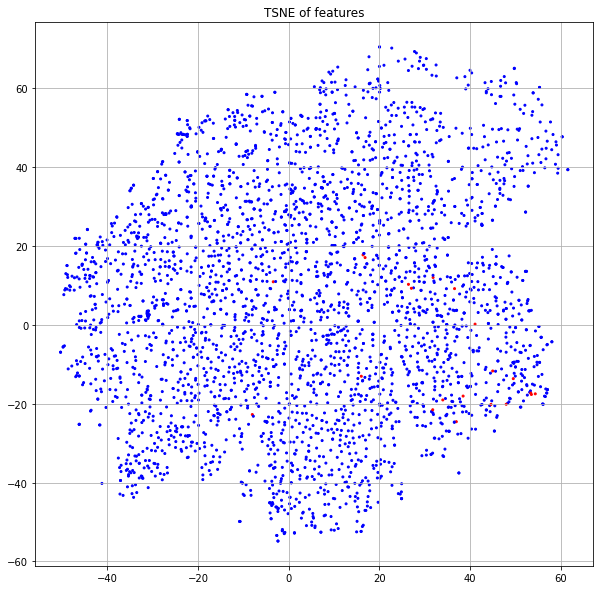

In [543]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wf[:,0], proj_wf[:,1], 
    c=np.array([n in idx_roi for n in range(proj.shape[0])]*1),
    s=4, cmap='bwr'
)

ax.set(title='TSNE of features')
_ = ax.grid()

In [560]:
idx_roi_wf = np.array([
    504,  569,  915, 1148, 1196, 1272, 1318, 1791, 2292, 2763,
    2819, 2913, 3153])

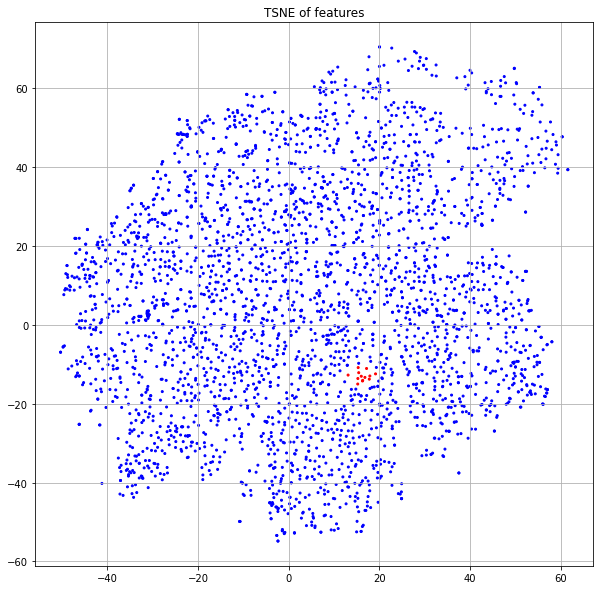

In [561]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wf[:,0], proj_wf[:,1], 
    c=np.array([n in idx_roi_wf for n in range(proj.shape[0])]*1),
    s=4, cmap='bwr'
)

ax.set(title='TSNE of features')
_ = ax.grid()

In [562]:
label[3153]

tensor(4)

In [563]:
# Labels of original points
label[idx_roi]

tensor([3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4])

In [564]:
# Labels of new neighborhood of isolated point
label[idx_roi_wf]

tensor([4, 2, 4, 0, 5, 4, 4, 4, 4, 4, 4, 4, 4])

In [643]:
mhops = 1
_, blocks_wf = sample_blocks(g.to('cpu'), [-1]*mhops, idx_roi_wf)
nns_wf = blocks_wf[0].ndata[dgl.NID]['_N'].numpy()

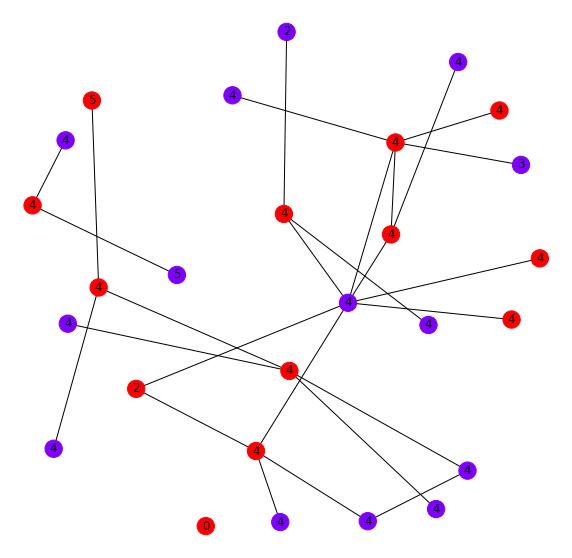

In [644]:
# Color by whether its in the seed list or a neighbor (red=original, blue=neighbor).  Label by its actual label.
label_map = {
    i: label[idx].numpy()
    for i, idx in enumerate(nns_wf)
}
node_color = np.array([n in idx_roi_wf for n in nns_wf]*1)
nx_G, pos = draw_kkl(
    g.subgraph(nns_wf).to('cpu'), 
    label_map=label_map,  
    node_color=node_color,
    cmap='rainbow'
)

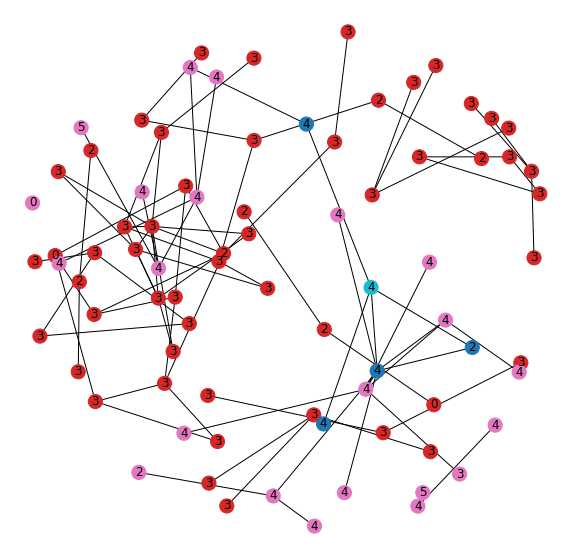

In [663]:
label_map = {
    i: label[idx].numpy()
    for i, idx in enumerate(nns_joint)
}

node_color = np.zeros(nns_joint.shape) # both neighborhoods, blue
node_color[[n not in nns_wf for n in nns_joint]] = 1 # original neighborhood only, red
node_color[[n not in nns for n in nns_joint]] = 2 # new neighborhood only, pink
node_color[np.array([n == 3153 for n in nns_joint])] = 3 # moving node, teal

nx_G, pos = draw_kkl(
    g.subgraph(nns_joint).to('cpu'), 
    label_map=label_map,  
    node_color=node_color,
    cmap='tab10',
    node_size=200,
)